# A script to get timespans between fire detection and TFR from Ororatech data

In [1]:
import geopandas as gpd
import pandas as pd
import datetime as dt
from datetime import timedelta
import sys

## Get the current fires

#### Fire clusters and TFR polygons need to get joined first. Then, calculation of time between fire detection and TFR being issued can be done.
As it turned out that ARTCCs issue TFRs beyond their FIR´s boundary, the entire fire cluster dataset has to be joined each time and will be read therefor.

In [2]:
##specify file location and name
#3 letter location indicator, reused within all created files
#possible values: ZAB ZDV ZFW ZLA ZLC ZMP ZOA ZSE; not ZKC and ZHU having no wildfire TFRs
tfr =r"ZDV"
#paths and filenames
fire_path = r"D:\UNIGIS\MASTER\DownloadedData\WFS\\"
tfr_path = r"D:\UNIGIS\MASTER\Scripts\\"
out_path = tfr_path

fire_file = "wfs-area-export_FIRs_Boundary_08-102021_con_pt5.geojson"
tfr_file = tfr + r"_fire_TFRs.geojson"

#create geodataframes
gdf_fires = gpd.read_file(fire_path + fire_file)
gdf_tfrs = gpd.read_file(tfr_path + tfr_file)

#set minutes_bf as search period to look at before TFR issue date
minutes_bf = 1440

#set start date of observed datasets
obs_start = pd.to_datetime('2021-08-01')

#no spatial output is generated here
#result lists filename
 # for Anaconda / excel output xltw module is required: conda install -c anaconda xlwt
result_list = out_path+tfr+'_afterDetectionTimes_list_noAPI.csv'

In [3]:
print('Fires: '+str(len(gdf_fires.index)))
print('TFRs: '+str(len(gdf_tfrs.index)))

Fires: 2926
TFRs: 28


Purge old TFRs issued before observation time that can hardly match fire data:


In [4]:
gdf_tfrs = gdf_tfrs[pd.to_datetime(gdf_tfrs["Issue Date (UTC)"]) >= obs_start]

Remove old fires already burning before observation time frame (and that would otherwise most probably get an accidentally intersecting younger TFR joined)

In [5]:
#sort out ongoing fires
#need to localize obs_start to compare to UTC format date
gdf_fires = gdf_fires[pd.to_datetime(gdf_fires["oldest_acquisition"]) >= obs_start.tz_localize('UTC') - timedelta(minutes = minutes_bf)]

In [6]:
print('Fires: '+str(len(gdf_fires.index)))
print('TFRs: '+str(len(gdf_tfrs.index)))

Fires: 2804
TFRs: 27


### Join fire clusters and TFRs


As the fire clusters used so far represent the largest extent of the fires within the observed time period (August to October 2021), without any temporal relation yet, the same fire may be tied to multiple TFRs. For fires close to each other, issuing one large contiguous TFR is allowed, so the same TFR might contain multiple fires as well. So the resulting geodataframe can contain a multiple of rows compared to the origin.


Geopandas sjoin is "one to many" automatically. To look for intersect is expected to deliver many fire clusters!

In [7]:
#perform join of gdfs
gdf_intersect = gpd.sjoin(gdf_fires, gdf_tfrs, how='inner', predicate='intersects')

In [8]:
# change the global options that Geopandas inherits from if more shall be displayed
# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
gdf_intersect.head(2)

,id,age,area,centroid,num_fires,confidence,newest_detection,oldest_detection,newest_acquisition,oldest_acquisition,...,Source,Location,NOTAM #,Issue Date (UTC),Effective Date (UTC),Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject,Radius,Radius_m
107,19806634,125497,2.007181e+07,"{'latitude': 45.060425, 'longitude': -105.961138}",140,1.0,2021-08-05T23:17:12+00:00,2021-08-02T03:49:31+00:00,2021-08-05T20:22:41+00:00,2021-08-02T03:09:51+00:00,...,ZDV_2021-08-05,ZDV,1/1635,08/05/2021 0233,08/05/2021 1400,08/07/2021 0427,09/30/2021 0400,!FDC 1/1635 ZDV MT..AIRSPACE 31NM SW OF BROADU...,7.0,12964.0
107,19806634,125497,2.007181e+07,"{'latitude': 45.060425, 'longitude': -105.961138}",140,1.0,2021-08-05T23:17:12+00:00,2021-08-02T03:49:31+00:00,2021-08-05T20:22:41+00:00,2021-08-02T03:09:51+00:00,...,ZDV_2021-08-05,ZDV,1/1585,08/05/2021 0019,08/05/2021 0015,None,08/05/2021 0400,!FDC 1/1585 ZDV CANCELLED BY FDC 1/1659 ON 08/...,7.0,12964.0


This is one theoretical possible "exit point": If nothing intersects, then the resulting geodataframe has 0 rows. 

Number of intersections

In [9]:
print(len(gdf_intersect.index))

19


In [10]:
# exit script with an empty result file if intersect geodataframe has 0 rows
if len(gdf_intersect.index) ==0:
    gdf_intersect.to_csv(result_list, columns=['id'], header=['No data from '+tfr])
    sys.exit(0)

ZDV : 20

A problem is that a TFR might have been issuded based on ground information while EO has not discovered a fire yet. So a TFR dedicated to a fire cluster might have become issued also hours before the cluster appears within Ororatech´s data.

Now it is important to understand what the result the intersect can be. If a 3-month-fire-cluster intersected with more TFRs, then different oldest acquisition and detection dates are possible to be contained in the above gdf_intersect. Removing duplicates concerning fire cluster id would deliver the first TFR for each fire event then, but this leads to addtional skewed results where a TFR overlaps multiple fire clusters (thus, also a younger fire, which does happen e.g. in ZSE). 
So, another solution to narrow down results is chosen to perform the calculation for all fires on all TFRs and then sort by the absolute value sum to keep the TFR that was issued with the lowest temporal distance to the fire, assuming that this is the TFR intended for the fire.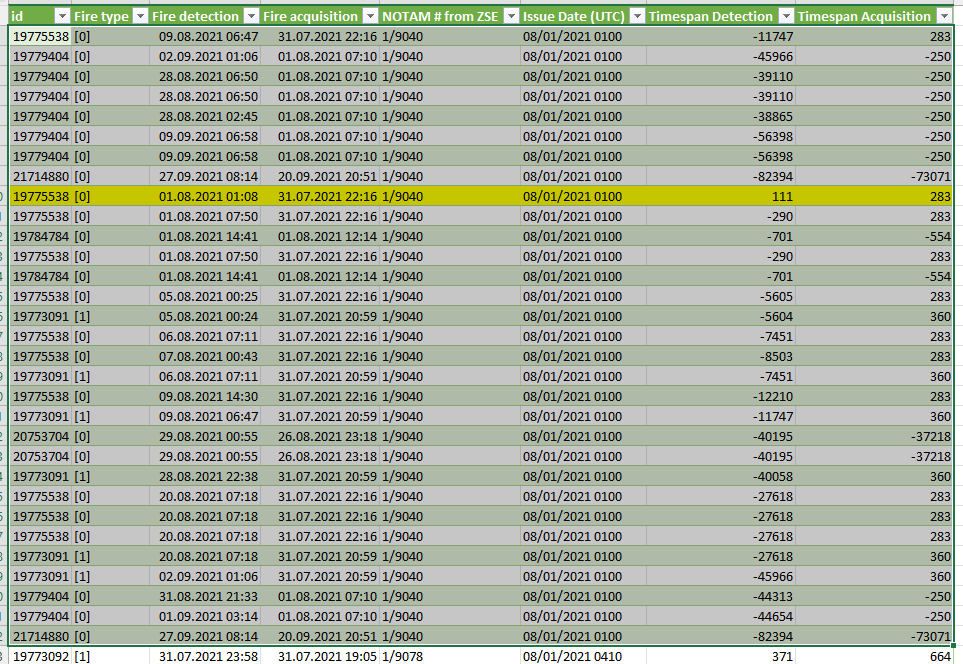

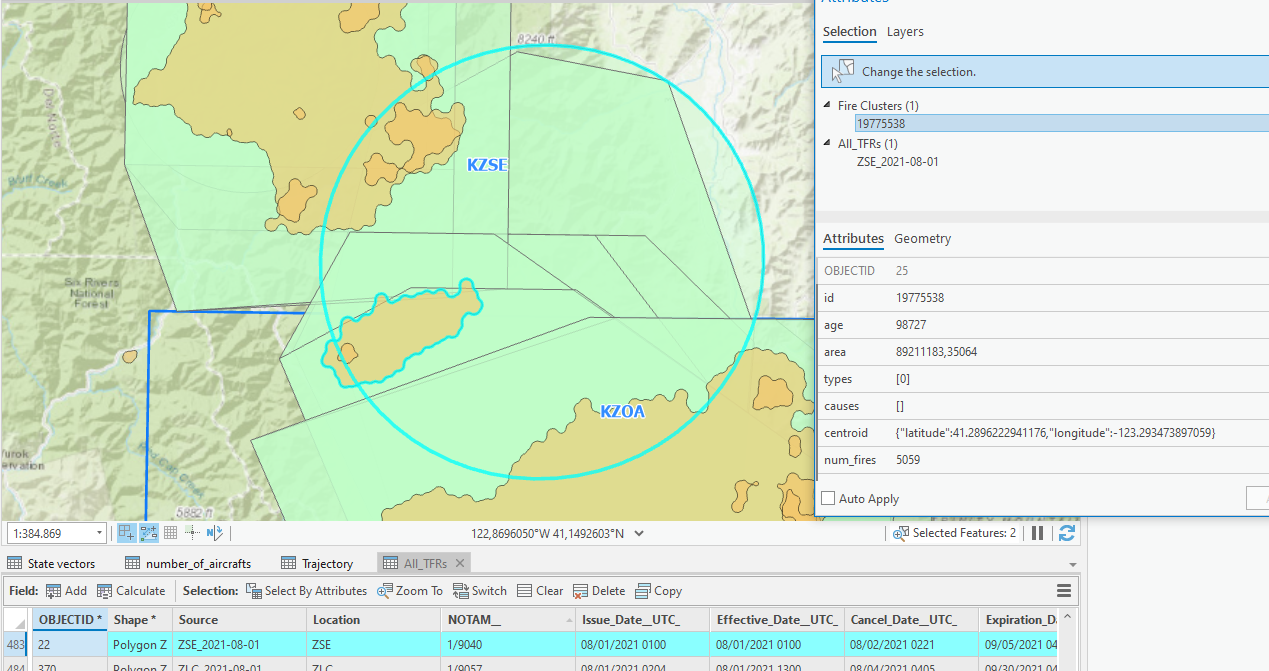


In [11]:
# set gdf_current_intersect as final gdf_result sort gdf by TFR issue date for an interim overview
gdf_result = gdf_intersect.sort_values(["Issue Date (UTC)"])
# gdf_result

A timespan between fire detection/acquisition and TFR issue time can be calculated (and turned to minutes). Oldest detection/acquisition time is subtracted from TFR issue date.

In [12]:
#calculate timespans column wise
# both times to calculate with are UTC but Python does not know yet
# for 'Issue Date (UTC)', as the format does not indicate by "+00:00"
#pd.to_datetime(gdf_result["Issue Date (UTC)"].tz_localize('UTC') ) is used

#.astype(int) returns an integer being sufficient as minute value

#oldest_detection
gdf_result["Calc_time_det"] = pd.to_datetime(gdf_result.loc[:,"Issue Date (UTC)"]).dt.tz_localize('UTC') - pd.to_datetime(gdf_result["oldest_detection"])
gdf_result["Timespan Detection"] = gdf_result.loc[:,"Calc_time_det"].dt.total_seconds().div(60).astype(int)

#oldest_acquisition
gdf_result["Calc_time_acq"] = pd.to_datetime(gdf_result.loc[:,"Issue Date (UTC)"]).dt.tz_localize('UTC') - pd.to_datetime(gdf_result["oldest_acquisition"])
gdf_result["Timespan Acquisition"] = gdf_result.loc[:,"Calc_time_acq"].dt.total_seconds().div(60).astype(int)

In FIRs with a lot of overlapping patterns, this leads to a lot of duplicates of fire ids and TFRs

In [13]:
#count duplicates (fire id)
gdf_result.duplicated(["id"]).sum()

9

In [14]:
#count non-duplicates
(~gdf_result.duplicated(["id"])).sum()

10

In [15]:
# Check: duplicates of TFRs
gdf_result.duplicated(["NOTAM #"]).sum()

0

In [16]:
#count non-duplicates TFRs
(~gdf_result.duplicated(["NOTAM #"])).sum()

19

To filter for the most trustworthy combination (meaning: To match a fire cluster and the TFR wich was the first one intended for it), the absolute temporal distance of a fire cluster from a TFR issue date needs to be summed up for both, detection and acquisition, then the lowest value must be chosen. This matches the highlighted correct cluster/TFR combination from the ZSE screenshot from excel above.

In [17]:
# sum up absolute times
gdf_result["Abs_time"] = gdf_result.loc[:,"Timespan Detection"].abs() + gdf_result.loc[:,"Timespan Acquisition"].abs()

In [18]:
gdf_result = gdf_result.sort_values(["Abs_time"])
# gdf_result

In [19]:
# spec 'id' column for dropping duplicates, first occurrence and therefor smallest Abs_time (after sorting above) is kept by default
gdf_result = gdf_result.drop_duplicates(subset=['id'])

If fire clusters for all TFRs exist, the gdf_result has the same row count as gdf_tfrs. But most probably, sometimes multiple TFRs had to be issued for the same fire event. So length of gdf is not meaningful then.

In [20]:
print(len(gdf_tfrs.index))

27


In [21]:
print(len(gdf_result.index))

10


Not all previously intersected fire clusters are still contained: Not for all of them a specific TFR might have been intended.

In [22]:
# Select fire clusters from first intersect, then check for those not represented:
options = gdf_result["id"]
gdf_fires_not_found = gdf_intersect[( ~gdf_intersect["id"].isin(options) )]
#print(len(gdf_fires_not_found.index))
print ('Fire clusters not incorporated: '  )
(~gdf_fires_not_found.duplicated(["id"])).sum()


Fire clusters not incorporated: 


0

Number of results: ZDV : 9 (as expected from checking In ArcGIS Pro )

In [23]:
gdf_result.head(2)

,id,age,area,centroid,num_fires,confidence,newest_detection,oldest_detection,newest_acquisition,oldest_acquisition,...,Cancel Date (UTC),Expiration Date (UTC),NOTAM Condition or LTA Subject,Radius,Radius_m,Calc_time_det,Timespan Detection,Calc_time_acq,Timespan Acquisition,Abs_time
427,20177190,116134,1.103887e+07,"{'latitude': 44.324449, 'longitude': -103.591332}",23,1.0,2021-08-12T10:58:57+00:00,2021-08-11T23:25:58+00:00,2021-08-12T08:26:06+00:00,2021-08-11T21:00:13+00:00,...,None,08/12/2021 0400,!FDC 1/5720 ZDV CANCELLED BY FDC 1/5865 ON 08/...,5.0,9260.0,0 days 00:15:02,15,0 days 02:40:47,160,175
1397,21594740,62847,5.210744e+07,"{'latitude': 42.597224, 'longitude': -103.454031}",781,1.0,2021-09-18T11:01:43+00:00,2021-09-17T03:59:11+00:00,2021-09-18T08:33:09+00:00,2021-09-16T19:15:05+00:00,...,09/17/2021 1812,11/18/2021 0200,!FDC 1/9881 ZDV NE..AIRSPACE 8NM S OF CRAWFORD...,7.0,12964.0,-1 days +20:39:49,-200,0 days 05:23:55,323,523


Finally, compose an output file as csv to list timespan between detection and TFR issue time

In [24]:
# write output to file
#column no ,'types' ; header no ,'Fire type'
gdf_result.to_csv(result_list, columns=['id', 'oldest_detection','oldest_acquisition', 'NOTAM #','Issue Date (UTC)', 'Timespan Detection', 'Timespan Acquisition'], header=['id', 'Fire detection','Fire acquisition', 'NOTAM # from '+tfr,'Issue Date (UTC)', 'Timespan Detection', 'Timespan Acquisition'], index=None, sep=' ', mode='w')

This Notebook ends here. 